In [2]:
import numpy as np
from scipy import signal
from scipy.signal import butter, lfilter, iirnotch
import matplotlib.pyplot as plt

In [3]:
#t = np.linspace(0,4*2000, 2000);
data = [signal.rstrip('\n') for signal in open('DataN.txt')]
signals = []
for signal in signals:
    signals.append(float(signal))

In [6]:
def notch_filter(noisy_signals, sampling_rate, dc_component, quality_factor: int = 30):
    
    b, a = iirnotch(dc_component, quality_factor, sampling_rate)
    noise_free_signals = lfilter(b, a, noisy_signals)
    
    return noise_free_signals

In [7]:
def butter_bandpass_filter(noisy_signals, lowcut, highcut, sampling_rate, order: int = 5):
    nyq = 0.5 * sampling_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    noise_free_signals = lfilter(b, a, noisy_signals)
    return noise_free_signals

In [6]:
def derivatise(signals):
    filterd_signals= np.zeros((len(signals)))
    filterd_signals[0:2] = signals[0:2]

    T = 1/256
    for s in range(2,len(signals)-2):
        op = -float(signals[s-1])
        op -= (2*(float(signals[s-2])))
        op += (2*(float(signals[s+2])))
        op += (float(signals[s+1]))
        op *= (1/(8*T))
        filterd_signals[s] += op
    
    return filterd_signals

In [5]:
def square_signals(differentiated_signals):
    squared_signals = []
    for signal in differentiated_signals:
        squared_signals.append(np.square(signal))
    return squared_signals     

In [9]:
def smoothen(signals, N):
    smoothed_signals = np.zeros((len(signals)))
    smoothed_signals[0:N] = signals[0:N]
    for s in range(N, len(signals)):
        for n in range(N, -1, -1):
            smoothed_signals[s] += (signals[s-n])
        smoothed_signals[s] *= (1/N)
    return smoothed_signals

In [10]:
def setThreshold(signals, N):
    threshold=0
    start=0
    end=N
    for i in range(0, (len(signals))-1):
        threshold+= max(signals[start:end])
        start+=1
        end+=1
    threshold/= len(signals)
    return threshold

In [2]:
def FindRPeaks(signals, T):
    peaks=[]
    for signal in signals:
        if(signal>=T):
            peaks.append(signal)
    return peaks

# Deliverables

### Signals After Filtering

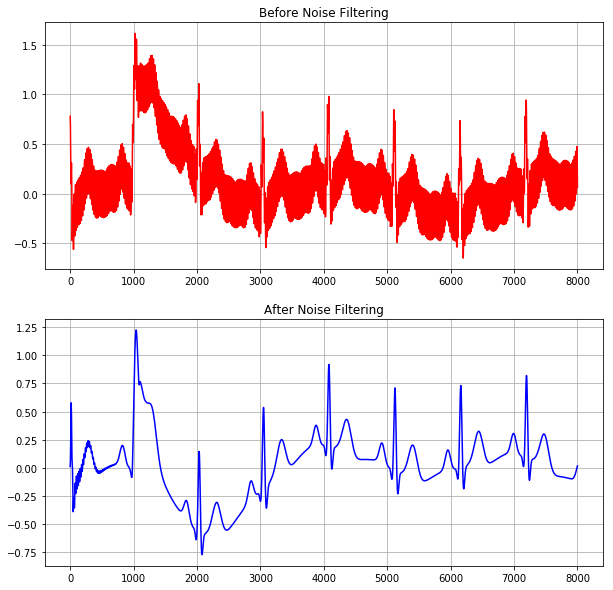

In [20]:
sample_rate =256
frequency_to_remove = 50
low_cut_frequncy = 0.1
high_cut_frequncy = 45
time_axis = np.linspace(0,4*2000, 2000);

dc_component_removed = notch_filter(data[0:2000], sample_rate, frequency_to_remove)
noise_free_signals = butter_bandpass_filter(dc_component_removed, low_cut_frequncy, high_cut_frequncy, sample_rate)

figure, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].grid()
ax[0].plot(time_axis, data[0:2000], color='red')
ax[0].title.set_text('Before Noise Filtering')
ax[1].plot(time_axis, noise_free_signals, color='blue')
ax[1].grid()
ax[1].title.set_text('After Noise Filtering')


plt.show()
figure.savefig('Before_After_Filter.jpg')

In [ ]:
square_signals